## other idea
remove duplicates using running time 
    -> problem because same movies have 1 minute difference in running time in the two data sets
try to use anoter dataset than basics that has things in common with our dataset for removal of duplicates

### Ideal
finding mapping between movie id

data set:
https://datasets.imdbws.com/

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols

In [2]:
movie = pd.read_csv("data/movie.metadata.tsv", delimiter='\t',header=None)
character = pd.read_csv("data/character.metadata.tsv", delimiter='\t',header=None)
movie.columns = ['Wikipedia movie ID','Freebase movie ID','Movie name','Movie release date','Movie box office revenue','Movie runtime','Movie languages','Movie countries','Movie genres']
movie["Movie name"] = movie["Movie name"].str.capitalize()
movie["Movie name"] = movie["Movie name"].str.replace(r'[éè]', 'e', regex=True)

In [3]:
# imdb1 has ratings, imdb identifier and number of votes
imdb1 = pd.read_csv('data/title.ratings (1).tsv', delimiter='\t')
# imdb2 has genres, title, year, etc
imdb2 = pd.read_csv('data/title.basics.tsv', delimiter='\t', low_memory=False)
merged_df = pd.merge(imdb1, imdb2, on='tconst', how='inner')
# in the imdb data set they include series and a lot of other things.
#  This removes a lot of movies that are not in the other data 
merged_2 = merged_df[(merged_df.titleType == 'movie')|(merged_df.titleType == 'tvMovie')]
# removing all the movies that have less than 30 votes 
# questionable step because some of the movies in our data set have 
# very low amount of votes
merged_3= merged_2[merged_2['numVotes'] >= 30]
# making the titles of the movies in the same format for both data set 
# for example in one data set a movie can be called "The matrix" and in the other "The Matrix"
merged_3.loc[:, 'primaryTitle'] = merged_3['primaryTitle'].str.capitalize()

In [5]:
# removing all the columns that are not needed
merged_4 = merged_3.drop(columns=['numVotes' ,'titleType', 'isAdult', 'endYear', 'originalTitle', 'runtimeMinutes', 'genres', 'tconst'])
# merging the data sets on our movie data set
merged_final = pd.merge(merged_4, movie, left_on='primaryTitle', right_on='Movie name', how='right')
# creating a column that has the year of the movie release so that we can remove duplicates 
# that have the same name but different release year
merged_final["Movie release year"] = merged_final["Movie release date"].str[:4]
# trying to remove duplicates
merged_final2 = merged_final[merged_final['Movie release year']==merged_final['startYear']]
# drop colllumn that are not needed
merged_final2 = merged_final2.drop(columns=['primaryTitle', 'startYear', 'Movie release date'])
merged_final2 = merged_final2[merged_final2['Movie box office revenue'].notna()]

# The best data right now

In [6]:
merged_final2 = merged_final2.drop(merged_final2[merged_final2['Movie box office revenue'].isnull()].index)
merged_final['startYear'] = pd.to_numeric(merged_final['startYear'], errors='coerce').astype('Int64')

In [13]:
# new_df = pd.read_csv('data/TMDB_movie_dataset_v11.csv')
# a = new_df['release_date'].sort_values()
# a.head(20)

In [7]:
inflation = pd.read_excel('data/CPI-US-Iflation.xlsx',header=None)
inflation.columns = ['Year','CPI']
inflation['rate'] = 1
inflation = inflation.drop(inflation[inflation['Year'] > 2020].index)
#calculate the currency rate
for i in range(len(inflation)):
    inf = 1
    for j in range(len(inflation)-1,i,-1):
        inf = (1 + inflation['CPI'].iloc[j]/100.0)*inf
    inflation['rate'].iloc[i] = inf

C:\Users\Mao\AppData\Local\Temp\ipykernel_22828\3569157639.py:10: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  inflation['rate'].iloc[i] = inf
C:\Users\Mao\AppData\Local\Temp\ipykernel_22828\3569157639.py:10: SettingWithCopyWarning: 
A valu

In [8]:
merged_final2['Movie release year'] = merged_final2['Movie release year'].astype('int')
inflation['Year'] = inflation['Year'].astype('int')
merged_final2 = pd.merge(inflation, merged_final2, left_on='Year', right_on='Movie release year', how='right').drop(columns=['CPI'])
merged_final2['Adjusted_Revenue'] = merged_final2['Movie box office revenue']*merged_final2['rate']

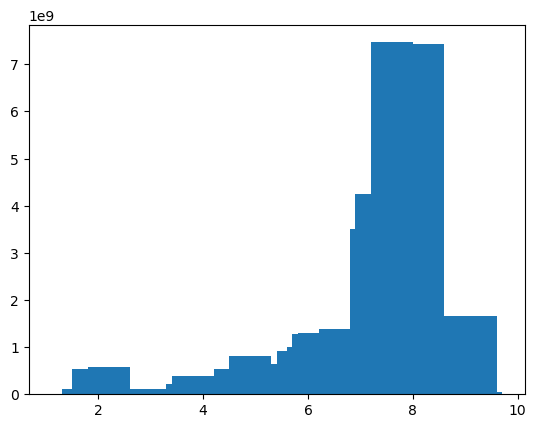

In [9]:
data = sns.load_dataset("tips")  # Seaborn自带的示例数据集
plt.bar(merged_final2['averageRating'], merged_final2['Adjusted_Revenue'])
plt.show()

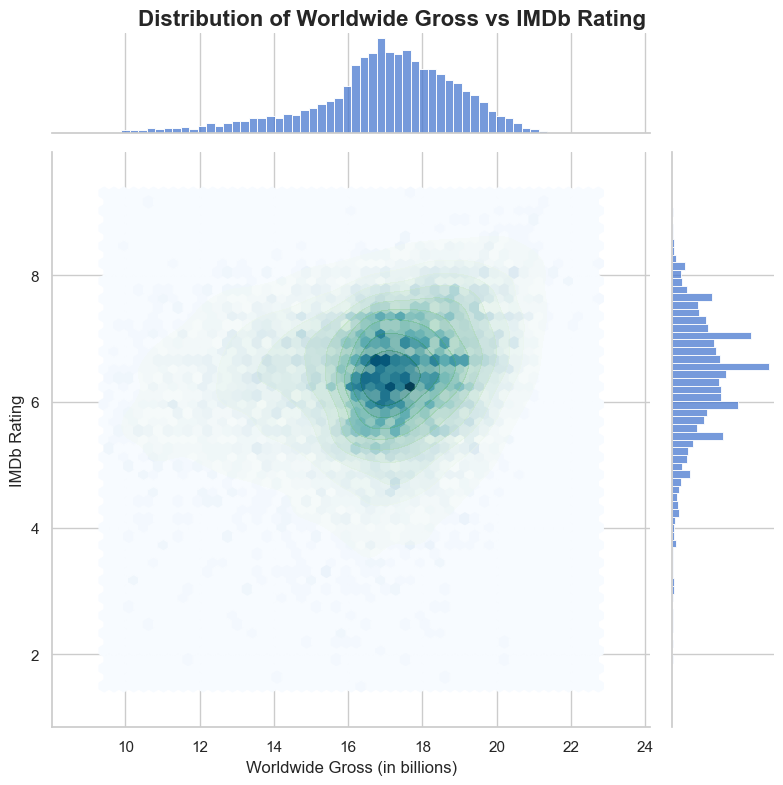

In [10]:
merged_final2['logMovieboxofficerevenue'] = np.log1p(merged_final2['Adjusted_Revenue'])
merged_final2.drop(merged_final2[merged_final2['logMovieboxofficerevenue'].isnull()].index, inplace=True)
sns.set_theme(style="whitegrid", palette="muted")
g = sns.jointplot(data=merged_final2, x='logMovieboxofficerevenue', y='averageRating', kind="hex", cmap="Blues", height=8,gridsize=50)
sns.kdeplot(data=merged_final2, x='logMovieboxofficerevenue', y='averageRating', cmap="Greens", fill=True, alpha=0.3, ax=g.ax_joint)
g.fig.suptitle("Distribution of Worldwide Gross vs IMDb Rating", fontsize=16, weight='bold', ha='center')
g.set_axis_labels("Worldwide Gross (in billions)", "IMDb Rating", fontsize=12)
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.95)
plt.show()

In [171]:

model = smf.ols(formula='logMovieboxofficerevenue ~ averageRating', data=merged_final2).fit(cov_type='HC2')
print(model.summary())

                               OLS Regression Results                               
Dep. Variable:     logMovieboxofficerevenue   R-squared:                       0.042
Model:                                  OLS   Adj. R-squared:                  0.042
Method:                       Least Squares   F-statistic:                     289.9
Date:                      Sun, 10 Nov 2024   Prob (F-statistic):           8.43e-64
Time:                              15:02:00   Log-Likelihood:                -15747.
No. Observations:                      7439   AIC:                         3.150e+04
Df Residuals:                          7437   BIC:                         3.151e+04
Df Model:                                 1                                         
Covariance Type:                        HC2                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------

In [11]:
coefficients = model.params
# 预测值
predictions = model.predict()
std_dev = np.std(predictions - merged_final2['logMovieboxofficerevenue'])
# 绘制散点图和回归线
plt.figure(figsize=(10, 6))
plt.scatter(merged_final2['averageRating'], merged_final2['logMovieboxofficerevenue'], color='skyblue', label='Actual Data')
plt.plot(merged_final2['averageRating'], predictions, color='orange', label='Regression Line')
plt.plot(merged_final2['averageRating'], predictions + std_dev, color='green', linestyle='--', label='+1 Std Dev')
plt.plot(merged_final2['averageRating'], predictions - std_dev, color='red', linestyle='--', label='-1 Std Dev')
plt.xlabel('Average Rating')
plt.ylabel('Log of Movie Box Office Revenue')
plt.title('Linear Regression of Log Box Office Revenue on Average Rating')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

NameError: name 'model' is not defined

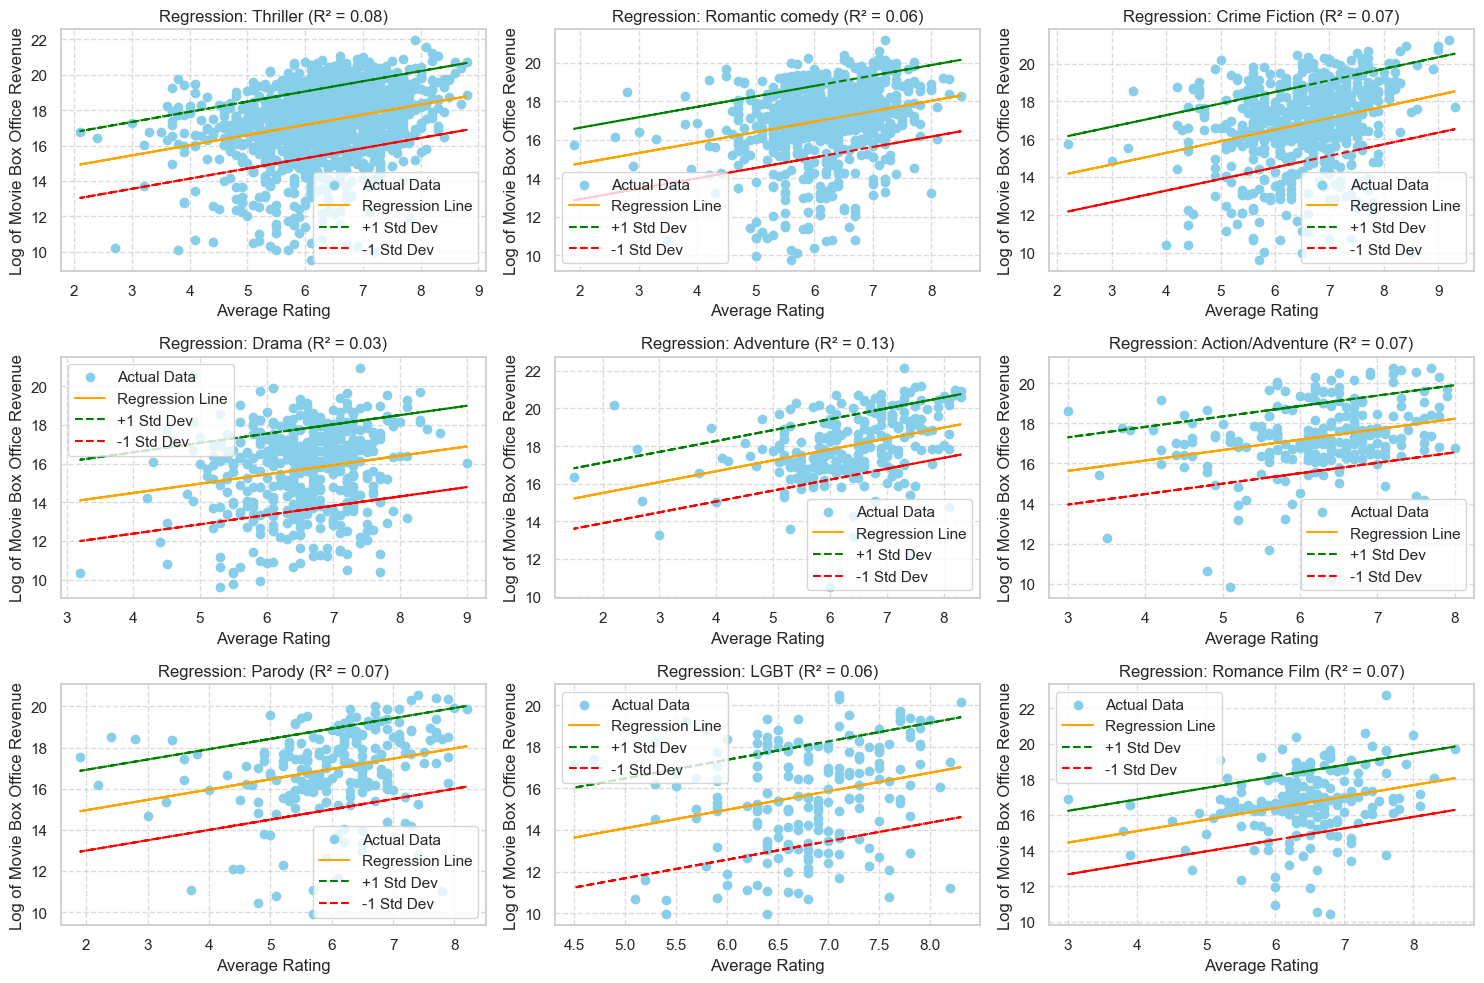

In [24]:
merged_final2['Movie countries'] = merged_final2['Movie genres'].apply(lambda x: list(json.loads(x).values()))
merged_final2['Primary Country'] = merged_final2['Movie countries'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None)
selected_countries = merged_final2['Primary Country'].value_counts().sort_values(ascending=False).head(9).index.tolist()
subset = merged_final2[merged_final2['Primary Country'].isin(selected_countries)]

plt.figure(figsize=(15, 10))
for i, country in enumerate(selected_countries, 1):
    plt.subplot(3, 3, i)  
    country_data = subset[subset['Primary Country'] == country]
    model = smf.ols(formula='logMovieboxofficerevenue ~ averageRating', data=country_data).fit(cov_type='HC2')
    coefficients = model.params
    predictions = model.predict()
    r2_score = model.rsquared_adj
    std_dev = np.std(predictions - country_data['logMovieboxofficerevenue'])
    plt.scatter(country_data['averageRating'], country_data['logMovieboxofficerevenue'], color='skyblue', label='Actual Data')
    plt.plot(country_data['averageRating'], predictions, color='orange', label='Regression Line')
    plt.plot(country_data['averageRating'], predictions + std_dev, color='green', linestyle='--', label='+1 Std Dev')
    plt.plot(country_data['averageRating'], predictions - std_dev, color='red', linestyle='--', label='-1 Std Dev')
    plt.xlabel('Average Rating')
    plt.ylabel('Log of Movie Box Office Revenue')
    plt.title(f'Regression: {country} (R² = {r2_score:.2f})')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

e:\anaconda3\envs\ada\Lib\site-packages\statsmodels\regression\linear_model.py:1795: RuntimeWarning: invalid value encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
e:\anaconda3\envs\ada\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
e:\anaconda3\envs\ada\Lib\site-packages\statsmodels\regression\linear_model.py:2003: RuntimeWarning: divide by zero encountered in divide
  self.het_scale = self.wresid**2/(1-h)


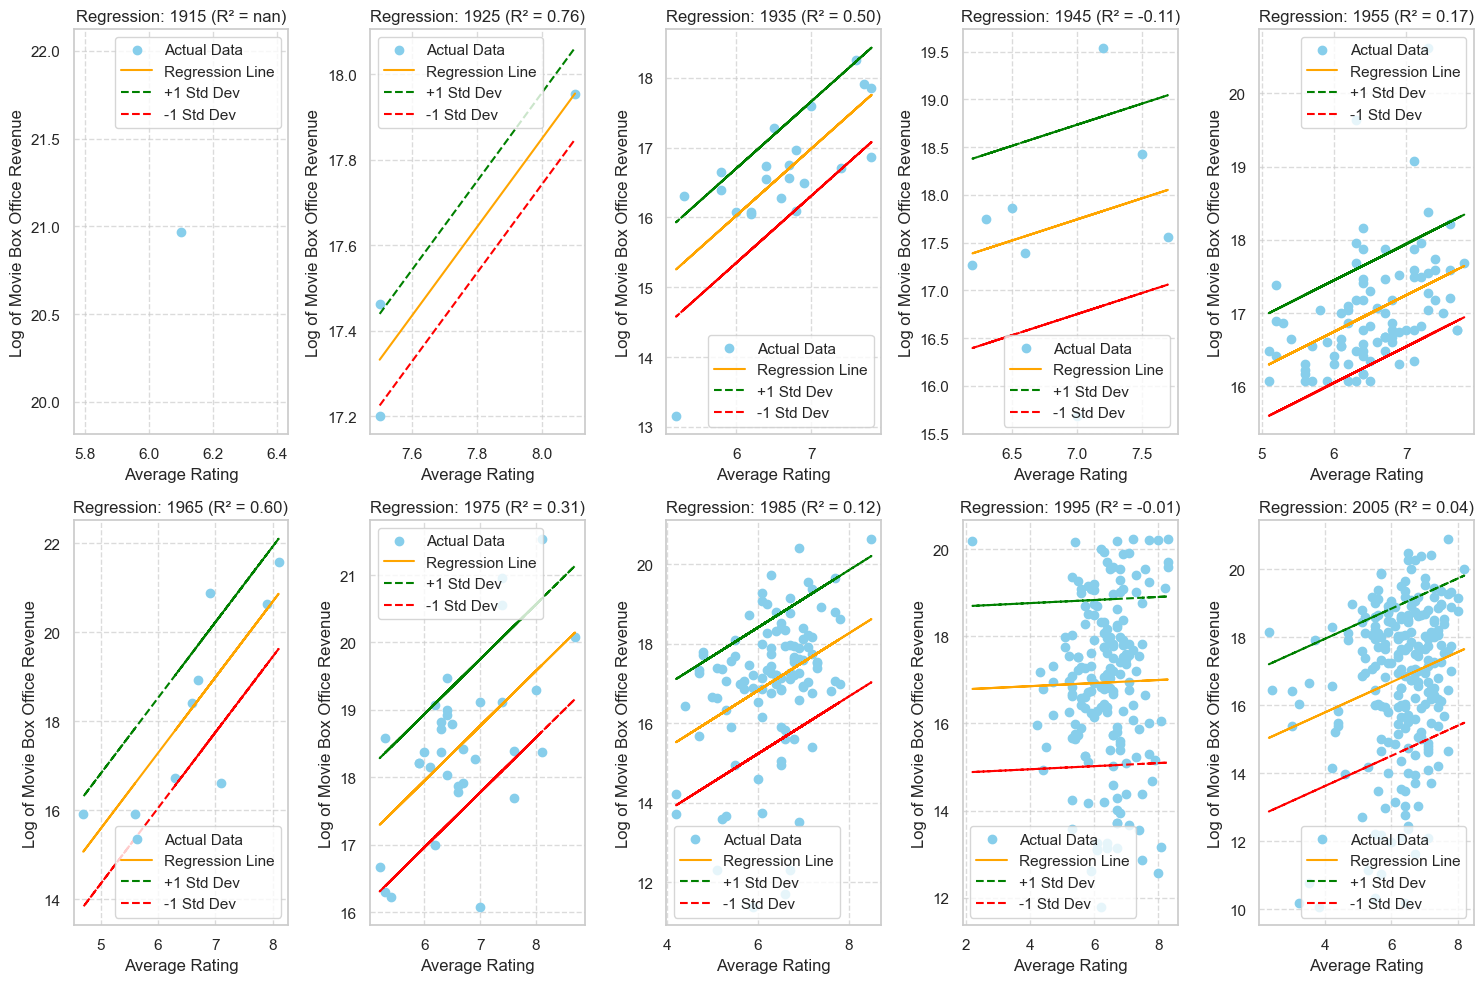

In [25]:
merged_final2['Year'].max()
selected_years = range(1915,2015,10)
subset = merged_final2[merged_final2['Year'].isin(selected_years)]

plt.figure(figsize=(15, 10))

for i, year in enumerate(selected_years, 1):
    plt.subplot(2, 5, i)  
    year_data = subset[subset['Year'] == year]
    model = smf.ols(formula='logMovieboxofficerevenue ~ averageRating', data=year_data).fit(cov_type='HC2')
    coefficients = model.params
    predictions = model.predict()
    r2_score = model.rsquared_adj
    std_dev = np.std(predictions - year_data['logMovieboxofficerevenue'])
    plt.scatter(year_data['averageRating'], year_data['logMovieboxofficerevenue'], color='skyblue', label='Actual Data')
    plt.plot(year_data['averageRating'], predictions, color='orange', label='Regression Line')
    plt.plot(year_data['averageRating'], predictions + std_dev, color='green', linestyle='--', label='+1 Std Dev')
    plt.plot(year_data['averageRating'], predictions - std_dev, color='red', linestyle='--', label='-1 Std Dev')
    plt.xlabel('Average Rating')
    plt.ylabel('Log of Movie Box Office Revenue')
    plt.title(f'Regression: {year} (R² = {r2_score:.2f})')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [19]:
residuals = merged_final2['logMovieboxofficerevenue'] - predictions
outliers = merged_final2[np.abs(residuals) > std_dev]['logMovieboxofficerevenue']
print(outliers.count())
higher = merged_final2[residuals > std_dev].copy()
lower = merged_final2[residuals < -std_dev].copy()
print('length of higher:',len(higher),'length of lower:',len(lower))

NameError: name 'predictions' is not defined

In [18]:
import json
higher['Movie genres'] = higher['Movie genres'].apply(lambda x: list(json.loads(x).values()))
higher['Movie languages'] = higher['Movie languages'].apply(lambda x: list(json.loads(x).values()))
higher['Movie countries'] = higher['Movie countries'].apply(lambda x: list(json.loads(x).values()))
lower['Movie genres'] = lower['Movie genres'].apply(lambda x: list(json.loads(x).values()))
lower['Movie languages'] = lower['Movie languages'].apply(lambda x: list(json.loads(x).values()))
lower['Movie countries'] = lower['Movie countries'].apply(lambda x: list(json.loads(x).values()))

NameError: name 'higher' is not defined

In [254]:
higher.loc[:, 'First genre'] = higher['Movie genres'].apply(lambda x: x[0])
higher.loc[:, 'Second genre'] = higher['Movie genres'].apply(lambda x: x[1] if len(x) > 1 else None)
higher.loc[:, 'Third genre'] = higher['Movie genres'].apply(lambda x: x[2] if len(x) > 2 else None)

In [305]:
First_t10 = higher['First genre'].value_counts()
Second_t10 = higher['Second genre'].value_counts()
Third_t10 = higher['Third genre'].value_counts()
all_genres = pd.concat([higher['First genre'], higher['Second genre'], higher['Third genre']])
All_t10 = all_genres.value_counts().head(10)
All_t10

Thriller            337
Adventure           217
Crime Fiction       157
Science Fiction     154
Action/Adventure    135
Drama               130
Romantic comedy     118
Comedy              116
Romance Film        115
Action              108
Name: count, dtype: int64

In [306]:
data = np.zeros((len(set(All_t10)),3))
i = 0
for genre in All_t10.index:
    data[i,0] = First_t10.get(genre, 0)
    data[i,1] = Second_t10.get(genre, 0)
    data[i,2] = Third_t10.get(genre, 0)
    i = i + 1

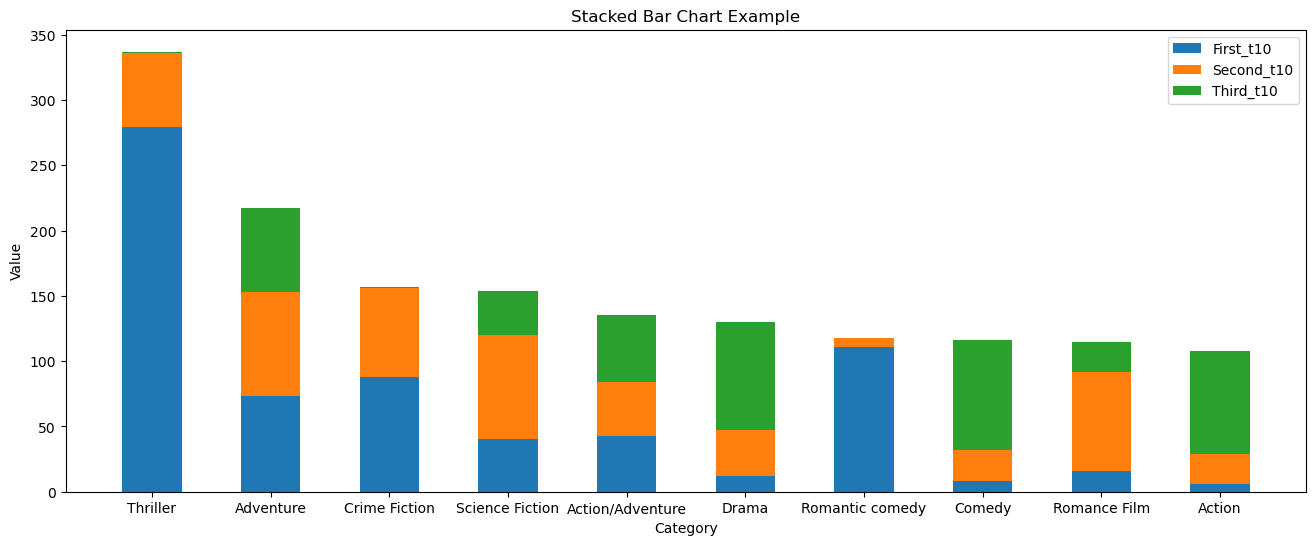

In [316]:
# 示例数据
categories = All_t10.index
subcategories = ['First_t10', 'Second_t10', 'Third_t10']

# 设置柱宽和偏移量
bar_width = 0.5
index = np.arange(len(categories))
plt.figure(figsize=(16, 6))
# 绘制每个分层的数据
for i in range(len(subcategories)):
    plt.bar(index, data[:, i], bar_width, label=subcategories[i], bottom=np.sum(data[:, :i], axis=1))

# 添加标签和标题
plt.xlabel('Category')
plt.ylabel('Value')
plt.title('Stacked Bar Chart Example')
plt.xticks(index, categories)
plt.legend()

plt.show()

In [237]:
higher['Number of genres'] = higher['Movie genres'].apply(lambda x: len(x) if isinstance(x, list) else 0)
higher['Number of genres'][higher['Number of genres']>3].count()

C:\Users\Mao\AppData\Local\Temp\ipykernel_8952\3678615329.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  higher['Number of genres'] = higher['Movie genres'].apply(lambda x: len(x) if isinstance(x, list) else 0)


896

In [190]:
# x=merged_final2['averageRating']
# x = (x -x.mean())/x.std()
# y=merged_final2['logMovieboxofficerevenue']
# y = (y -y.mean())/y.std()
# plt.hist(merged_final2['averageRating'])
# up=merged_final2['averageRating'].mean() + merged_final2['averageRating'].std()
# low=merged_final2['averageRating'].mean() - merged_final2['averageRating'].std()
# plt.hist(merged_final2['averageRating'])
# # Create an array of y values
# y = np.linspace(-10, 3000, 400)

# # Plot the vertical line x = 1
# plt.plot(up*np.ones_like(y), y, label="x = 1", color='red')
# plt.plot(low*np.ones_like(y), y, label="x = 1", color='red')
# merged_final2['averageRating'][(merged_final2['averageRating'] < up) & (merged_final2['averageRating'] > low)].count()
# merged_final2['averageRating']

In [189]:
# from sklearn.cluster import KMeans
# x=merged_final2['averageRating']
# x = (x -x.mean())/x.std()
# y=merged_final2['logMovieboxofficerevenue']
# y = (y -y.mean())/y.std()
# merged_final2['averageRating'] = (x - np.min(x)) / (np.max(x) - np.min(x))
# merged_final2['logMovieboxofficerevenue'] = (y - np.min(y)) / (np.max(y) - np.min(y))
# data = np.column_stack((x, y))
# #elbow
# sse = []
# k_range = range(1, 11)  
# for k in k_range:
#     kmeans = KMeans(n_clusters=k, random_state=42)
#     kmeans.fit(data)
#     sse.append(kmeans.inertia_)  
# plt.plot(k_range, sse, marker='o')
# plt.title('Elbow Method for Optimal k')
# plt.xlabel('Number of Clusters (k)')
# plt.ylabel('SSE (Inertia)')
# plt.show()

In [188]:
# kmeans = KMeans(n_clusters=4, random_state=42)  
# merged_final2['cluster'] = kmeans.fit_predict(data)  
# plt.figure(figsize=(8, 6))
# sns.scatterplot(x='averageRating', y='logMovieboxofficerevenue', hue='cluster', palette='Set1', data=merged_final2, s=100, edgecolor='black', marker='o')
# plt.title('K-means Clustering of 2D Data')
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.legend(title='Cluster')
# plt.show()